In [1]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [2]:
# ============================================================
# BƯỚC 1: CHUẨN BỊ DATAFRAME TỪ ẢNH (FAKE / REAL)
# ============================================================

# Define the path to the dataset
base_path =  r'C:\Users\3\Desktop\Dataset\celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Mapping label -> số
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})

# Tạo video_key: id_label (mỗi video)
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']

In [3]:
df

,filename,path,id,frame,label,label_id,video_key
0,000_id0_0000_frame_0000.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,0,fake,0,0_fake
1,000_id0_0000_frame_0001.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,1,fake,0,0_fake
2,000_id0_0000_frame_0002.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,2,fake,0,0_fake
3,000_id0_0000_frame_0003.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,3,fake,0,0_fake
4,000_id0_0000_frame_0004.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,4,fake,0,0_fake
...,...,...,...,...,...,...,...
32367,541_id9_0009_frame_0025.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,25,real,1,541_real
32368,541_id9_0009_frame_0026.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,26,real,1,541_real
32369,541_id9_0009_frame_0027.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,27,real,1,541_real
32370,541_id9_0009_frame_0028.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,28,real,1,541_real


In [4]:
# ============================================================
# BƯỚC 2: ĐỌC CSV FUSION: FFT + DCT + SRM + OPENFACE
# THAY THẾ CHO CSV OPENFACE CŨ
# ============================================================

print("📂 Loading pre-extracted OpenFace features from CSV files...")

# ĐƯỜNG DẪN FUSION CSV (fake / real)
csv_fake_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-CELEB\merge_frequency_openface_features_fake.csv'
csv_real_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-CELEB\merge_frequency_openface_features_real.csv'

# Kiểm tra tồn tại
if not os.path.exists(csv_fake_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_fake_path}")
if not os.path.exists(csv_real_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_real_path}")

# Đọc CSV có header
df_fake_features = pd.read_csv(csv_fake_path)
df_real_features = pd.read_csv(csv_real_path)

# Gộp chung fake + real
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)

# Đảm bảo cột đầu tiên là 'filename'
df_all_features.rename(columns={df_all_features.columns[0]: 'filename'}, inplace=True)

# Các cột metadata KHÔNG đưa vào vector feature
non_feature_cols = [
    'filename',
    'width', 'height', 'color_mode', 'resize_to', 'do_hann'
]
non_feature_cols = [c for c in non_feature_cols if c in df_all_features.columns]

# Tất cả cột còn lại là feature: SRM + DCT + FFT + OpenFace (feature_1..feature_674,...)
feature_cols = [c for c in df_all_features.columns if c not in non_feature_cols]

# Tạo dict: filename -> vector feature (fusion)
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row[feature_cols].values.astype('float32')
    openface_features[filename] = features

# Số chiều vector feature fusion
csv_feature_dim = len(feature_cols)

print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 16223 feature vectors
✅ Each vector has 958 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [5]:
# ============================================================
# BƯỚC 3: CẤU HÌNH MÔ HÌNH + TRAINING (TCN + MobileNetV2)
# ============================================================

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Conv1D, Add, Activation, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration - Enhanced
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16   # Reduced for better generalization
epochs = 100      # Increased for better convergence
n_splits = 5
sequence_len = 15 # Increased to capture more temporal information
results = []
all_histories = []


In [6]:
# ============================================================
# BƯỚC 4: NORMALIZE CSV FEATURES (FUSION) VỚI STANDARD SCALER
# ============================================================

print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

# Debug: Check if we have any features
print(f"📊 Found {len(all_csv_features)} CSV features from {len(video_keys)} videos")
if len(all_csv_features) == 0:
    print("⚠️ WARNING: No matching CSV features found!")
    print(f"   Sample video filename: {os.path.basename(list(video_dict.values())[0][0])}")
    print(f"   Sample CSV key: {list(openface_features.keys())[0]}")
    raise ValueError("No CSV features found - check filename matching!")

csv_scaler = StandardScaler()
csv_scaler.fit(np.array(all_csv_features))  # Convert to numpy array
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

🔧 Computing CSV feature statistics for normalization...
📊 Found 16253 CSV features from 1084 videos
✅ CSV feature normalization fitted on 16253 samples


In [7]:
# ============================================================
# BƯỚC 5: DATA GENERATOR CHO VIDEO + CSV FUSION
# ============================================================

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=15, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        # Enhanced augmentation for better regularization
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20 if augment else 0,
            width_shift_range=0.15 if augment else 0,
            height_shift_range=0.15 if augment else 0,
            zoom_range=0.15 if augment else 0,
            horizontal_flip=augment,
            brightness_range=[0.8, 1.2] if augment else None,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform(csv_feat.reshape(1, -1))[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)


In [8]:
# ============================================================
# BƯỚC 6: ĐỊNH NGHĨA KHỐI TCN RESIDUAL
# ============================================================

def tcn_residual_block(x, filters, kernel_size, dilation_rate, block_num):
    shortcut = x
    # First convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_1')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_1')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_1')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_1')(x)
    
    # Second convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_2')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_2')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_2')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_2')(x)
    
    # Residual connection with projection if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same', name=f'tcn_shortcut_{block_num}')(shortcut)
    
    x = Add(name=f'tcn_add_{block_num}')([x, shortcut])
    x = Activation('relu', name=f'tcn_out_relu_{block_num}')(x)
    return x

# ============================================================
# BƯỚC 7: XÂY DỰNG MÔ HÌNH TCN + MOBILENETV2 + CSV FUSION
# ============================================================

def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch with more trainable layers
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    # Fine-tune more layers for better feature extraction
    for layer in base_cnn.layers[:-30]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # Enhanced TCN blocks with increased capacity (256 filters)
    # Using dilations: 1, 2, 4, 8, 16, 32 for deeper temporal receptive field
    x = x_combined
    tcn_configs = [
        (256, 3, 1),   # dilation=1
        (256, 3, 2),   # dilation=2
        (256, 3, 4),   # dilation=4
        (256, 3, 8),   # dilation=8
        (128, 3, 16),  # dilation=16, reduced filters
        (128, 3, 32),  # dilation=32, reduced filters
    ]
    
    for i, (filters, kernel_size, dilation_rate) in enumerate(tcn_configs):
        x = tcn_residual_block(x, filters, kernel_size, dilation_rate, i+1)
    
    # Global average pooling over time dimension
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.3, name='dropout_global')(x)
    
    # Enhanced classification layers with more capacity
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='bn_dense_1')(x)
    x = Dropout(0.4, name='dropout_3')(x)
    
    x = Dense(64, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_dense_2')(x)
    x = Dropout(0.3, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='TCN_Residual_Enhanced')
    return model

# ============================================================
# BƯỚC 8: HMM POST-PROCESSING
# ============================================================

def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ============================================================
# BƯỚC 9: TRAINING VỚI K-FOLD CROSS-VALIDATION
# ============================================================

print("\n🚀 Starting Enhanced TCN + Residual Blocks Training:")
print("   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)")
print("   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128")
print("   ✅ Layer Normalization after each conv layer")
print("   ✅ Enhanced data augmentation")
print("   ✅ Sequence length: 15 frames")
print("   ✅ MobileNet (last 30 layers trainable)")
print("   ✅ Stronger regularization (dropout 0.3-0.4)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - Enhanced TCN_Residual")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.15, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    
    # Enhanced optimizer with learning rate
    initial_lr = 1e-4
    model.compile(
        optimizer=Adamax(learning_rate=initial_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n📈 Enhanced Model Architecture:")
    print(f"   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - Sequence length: {sequence_len}")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Initial learning rate: {initial_lr}")

    model_path = f"best_model_fold{fold}_tcn_res_enhanced.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    # Load best weights
    model.load_weights(model_path)

    # Evaluate
    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (Enhanced TCN_Residual):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - Enhanced TCN_Residual Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

# Calculate CV metrics
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

print(f"\n📈 Cross-Validation Stability:")
print(f"   Mean Accuracy: {accuracy_mean:.4f}")
print(f"   Std Deviation: {accuracy_std:.4f}")
print(f"   Range: {accuracy_range:.4f}")
print(f"   CV%: {accuracy_cv_percent:.2f}%")


🚀 Starting Enhanced TCN + Residual Blocks Training:
   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)
   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128
   ✅ Layer Normalization after each conv layer
   ✅ Enhanced data augmentation
   ✅ Sequence length: 15 frames
   ✅ MobileNet (last 30 layers trainable)
   ✅ Stronger regularization (dropout 0.3-0.4)
   ✅ HMM post-processing


📊 Fold 1/5 - Enhanced TCN_Residual



📈 Enhanced Model Architecture:
   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)
   - Total params: 6,247,097
   - Trainable params: 5,510,653
   - Sequence length: 15
   - Batch size: 16
   - Initial learning rate: 0.0001
Epoch 1/100


46/46 [==============================] - ETA: 0s - loss: 0.9242 - accuracy: 0.5204
Epoch 1: val_accuracy improved from -inf to 0.51908, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 238s 5s/step - loss: 0.9242 - accuracy: 0.5204 - val_loss: 0.7082 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.5204
Epoch 2: val_accuracy did not improve from 0.51908
46/46 [==============================] - 212s 5s/step - loss: 0.9435 - accuracy: 0.5204 - val_loss: 0.7046 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.9226 - accuracy: 0.5177
Epoch 3: val_accuracy improved from 0.51908 to 0.53435, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.9226 - accuracy: 0.5177 - val_loss: 0.7061 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.5285
Epoch 4: val_accuracy did not improve from 0.53435
46/46 [==============================] - 210s 5s/step - loss: 0.8728 - accuracy: 0.5285 - val_loss: 0.7242 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.9082 - accuracy: 0.5190
Epoch 5: val_accuracy did not improve from 0.53435
46/46 [==============================] - 209s 5s/step - loss: 0.9082 - accuracy: 0.5190 - val_loss: 0.7377 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.5068
Epoch 6: val_accuracy did not improve from 0.53435
46/46 [==============================] - 208s 5s/step - loss: 0.8964 - accuracy: 0.5068 - val_loss: 0.7718 - val_accuracy

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.8859 - accuracy: 0.5095
Epoch 2: val_accuracy improved from 0.51908 to 0.58015, saving model to best_model_fold2_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 212s 5s/step - loss: 0.8859 - accuracy: 0.5095 - val_loss: 0.6842 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.5353
Epoch 3: val_accuracy did not improve from 0.58015
46/46 [==============================] - 212s 5s/step - loss: 0.8632 - accuracy: 0.5353 - val_loss: 0.7094 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8395 - accuracy: 0.5543
Epoch 4: val_accuracy did not improve from 0.58015
46/46 [==============================] - 211s 5s/step - loss: 0.8395 - accuracy: 0.5543 - val_loss: 0.7337 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.5149
Epoch 5: val_accuracy did not improve from 0.58015
46/46 [==============================] - 209s 5s/step - loss: 0.8414 - accuracy: 0.5149 - val_loss: 0.7539 - val_accuracy

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📈 Enhanced Model Architecture:
   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)
   - Total params: 6,247,097
   - Trainable params: 5,510,653
   - Sequence length: 15
   - Batch size: 16
   - Initial learning rate: 0.0001
Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.5312
Epoch 1: val_accuracy improved from -inf to 0.50382, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 218s 5s/step - loss: 0.9055 - accuracy: 0.5312 - val_loss: 0.7618 - val_accuracy: 0.5038 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.5054
Epoch 2: val_accuracy improved from 0.50382 to 0.51145, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.9370 - accuracy: 0.5054 - val_loss: 0.7563 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8739 - accuracy: 0.5394
Epoch 3: val_accuracy did not improve from 0.51145
46/46 [==============================] - 211s 5s/step - loss: 0.8739 - accuracy: 0.5394 - val_loss: 0.7609 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.5598
Epoch 4: val_accuracy improved from 0.51145 to 0.52672, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.8252 - accuracy: 0.5598 - val_loss: 0.7602 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.5652
Epoch 5: val_accuracy improved from 0.52672 to 0.53435, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.8476 - accuracy: 0.5652 - val_loss: 0.8152 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.5924
Epoch 6: val_accuracy did not improve from 0.53435
46/46 [==============================] - 212s 5s/step - loss: 0.7824 - accuracy: 0.5924 - val_loss: 0.8731 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.5978
Epoch 7: val_accuracy did not improve from 0.53435

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
46/46 [==============================] - 210s 5s/step - loss: 0.7759 - accuracy: 0.5978 - val_loss: 1.0114 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.6046
Epoch 8: val_accuracy did not improve from 0.53435
46/46 [==============================] - 211

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.7287 - accuracy: 0.6399 - val_loss: 1.1027 - val_accuracy: 0.5420 - lr: 5.0000e-05
Epoch 10/100
46/46 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.6223
Epoch 10: val_accuracy improved from 0.54198 to 0.54962, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.7267 - accuracy: 0.6223 - val_loss: 1.0743 - val_accuracy: 0.5496 - lr: 5.0000e-05
Epoch 11/100
46/46 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.6685
Epoch 11: val_accuracy did not improve from 0.54962
46/46 [==============================] - 211s 5s/step - loss: 0.6744 - accuracy: 0.6685 - val_loss: 1.2017 - val_accuracy: 0.5420 - lr: 5.0000e-05
Epoch 12/100
46/46 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6834
Epoch 12: val_accuracy improved from 0.54962 to 0.55725, saving model to best_model_fold3_tcn_res_enhanced.h5

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6451 - accuracy: 0.6834 - val_loss: 1.1282 - val_accuracy: 0.5573 - lr: 5.0000e-05
Epoch 13/100
46/46 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.6562
Epoch 13: val_accuracy improved from 0.55725 to 0.56489, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.6804 - accuracy: 0.6562 - val_loss: 1.0413 - val_accuracy: 0.5649 - lr: 2.5000e-05
Epoch 14/100
46/46 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.6644
Epoch 14: val_accuracy improved from 0.56489 to 0.58779, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.6575 - accuracy: 0.6644 - val_loss: 0.9593 - val_accuracy: 0.5878 - lr: 2.5000e-05
Epoch 15/100
46/46 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.6902
Epoch 15: val_accuracy improved from 0.58779 to 0.60305, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6315 - accuracy: 0.6902 - val_loss: 0.9237 - val_accuracy: 0.6031 - lr: 2.5000e-05
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6603
Epoch 16: val_accuracy improved from 0.60305 to 0.61069, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6537 - accuracy: 0.6603 - val_loss: 0.8594 - val_accuracy: 0.6107 - lr: 2.5000e-05
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6793
Epoch 17: val_accuracy did not improve from 0.61069

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
46/46 [==============================] - 211s 5s/step - loss: 0.6610 - accuracy: 0.6793 - val_loss: 0.8300 - val_accuracy: 0.6107 - lr: 2.5000e-05
Epoch 18/100
46/46 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7364
Epoch 18: val_accuracy improved from 0.61069 to 0.63359, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.5765 - accuracy: 0.7364 - val_loss: 0.7645 - val_accuracy: 0.6336 - lr: 1.2500e-05
Epoch 19/100
46/46 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6889
Epoch 19: val_accuracy improved from 0.63359 to 0.65649, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 209s 5s/step - loss: 0.6352 - accuracy: 0.6889 - val_loss: 0.7216 - val_accuracy: 0.6565 - lr: 1.2500e-05
Epoch 20/100
46/46 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6957
Epoch 20: val_accuracy improved from 0.65649 to 0.68702, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.5922 - accuracy: 0.6957 - val_loss: 0.6749 - val_accuracy: 0.6870 - lr: 1.2500e-05
Epoch 21/100
46/46 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.7337
Epoch 21: val_accuracy improved from 0.68702 to 0.69466, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 210s 5s/step - loss: 0.5478 - accuracy: 0.7337 - val_loss: 0.6336 - val_accuracy: 0.6947 - lr: 1.2500e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.6889
Epoch 22: val_accuracy improved from 0.69466 to 0.74046, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.6400 - accuracy: 0.6889 - val_loss: 0.6074 - val_accuracy: 0.7405 - lr: 1.2500e-05
Epoch 23/100
46/46 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7174
Epoch 23: val_accuracy improved from 0.74046 to 0.75573, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.5797 - accuracy: 0.7174 - val_loss: 0.5713 - val_accuracy: 0.7557 - lr: 1.2500e-05
Epoch 24/100
46/46 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7133
Epoch 24: val_accuracy did not improve from 0.75573
46/46 [==============================] - 211s 5s/step - loss: 0.5559 - accuracy: 0.7133 - val_loss: 0.5554 - val_accuracy: 0.7557 - lr: 1.2500e-05
Epoch 25/100
46/46 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7079
Epoch 25: val_accuracy did not improve from 0.75573
46/46 [==============================] - 210s 5s/step - loss: 0.5991 - accuracy: 0.7079 - val_loss: 0.5313 - val_accuracy: 0.7405 - lr: 1.2500e-05
Epoch 26/100
46/46 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7310
Epoch 26: val_accuracy did not improve from 0.75573
46/46 [==============================] - 210s 5s/step - loss: 0.5489 - accuracy: 0.7310 - val_loss: 0.5072 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.5866 - accuracy: 0.7092 - val_loss: 0.4912 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7092
Epoch 29: val_accuracy did not improve from 0.77863
46/46 [==============================] - 210s 5s/step - loss: 0.5421 - accuracy: 0.7092 - val_loss: 0.4867 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7405
Epoch 30: val_accuracy did not improve from 0.77863
46/46 [==============================] - 210s 5s/step - loss: 0.5275 - accuracy: 0.7405 - val_loss: 0.4719 - val_accuracy: 0.7710 - lr: 1.2500e-05
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.7351
Epoch 31: val_accuracy improved from 0.77863 to 0.78626, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.5479 - accuracy: 0.7351 - val_loss: 0.4616 - val_accuracy: 0.7863 - lr: 1.2500e-05
Epoch 32/100
46/46 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7364
Epoch 32: val_accuracy did not improve from 0.78626
46/46 [==============================] - 211s 5s/step - loss: 0.5472 - accuracy: 0.7364 - val_loss: 0.4603 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 33/100
46/46 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.7514
Epoch 33: val_accuracy did not improve from 0.78626
46/46 [==============================] - 210s 5s/step - loss: 0.5295 - accuracy: 0.7514 - val_loss: 0.4490 - val_accuracy: 0.7863 - lr: 1.2500e-05
Epoch 34/100
46/46 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7446
Epoch 34: val_accuracy did not improve from 0.78626
46/46 [==============================] - 212s 5s/step - loss: 0.5170 - accuracy: 0.7446 - val_loss: 0.4324 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 220s 5s/step - loss: 0.9058 - accuracy: 0.5177 - val_loss: 0.8718 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 0.5394
Epoch 2: val_accuracy did not improve from 0.51145
46/46 [==============================] - 211s 5s/step - loss: 0.8865 - accuracy: 0.5394 - val_loss: 0.7893 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8659 - accuracy: 0.5380
Epoch 3: val_accuracy improved from 0.51145 to 0.51908, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.8659 - accuracy: 0.5380 - val_loss: 0.8145 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.5326
Epoch 4: val_accuracy did not improve from 0.51908
46/46 [==============================] - 210s 5s/step - loss: 0.8796 - accuracy: 0.5326 - val_loss: 0.7784 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.5149
Epoch 5: val_accuracy improved from 0.51908 to 0.55725, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.8919 - accuracy: 0.5149 - val_loss: 0.7060 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.8002 - accuracy: 0.5707
Epoch 6: val_accuracy improved from 0.55725 to 0.58779, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 211s 5s/step - loss: 0.8002 - accuracy: 0.5707 - val_loss: 0.6889 - val_accuracy: 0.5878 - lr: 1.0000e-04
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.5448
Epoch 7: val_accuracy improved from 0.58779 to 0.60305, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 212s 5s/step - loss: 0.8796 - accuracy: 0.5448 - val_loss: 0.6822 - val_accuracy: 0.6031 - lr: 1.0000e-04
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.5462
Epoch 8: val_accuracy did not improve from 0.60305
46/46 [==============================] - 210s 5s/step - loss: 0.8063 - accuracy: 0.5462 - val_loss: 0.6770 - val_accuracy: 0.5954 - lr: 1.0000e-04
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.5435
Epoch 9: val_accuracy did not improve from 0.60305
46/46 [==============================] - 209s 5s/step - loss: 0.8378 - accuracy: 0.5435 - val_loss: 0.6890 - val_accuracy: 0.5954 - lr: 1.0000e-04
Epoch 10/100
46/46 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.5774
Epoch 10: val_accuracy did not improve from 0.60305
46/46 [==============================] - 211s 5s/step - loss: 0.8212 - accuracy: 0.5774 - val_loss: 0.7533 - val_accura

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.7102 - accuracy: 0.6359 - val_loss: 0.8136 - val_accuracy: 0.6260 - lr: 5.0000e-05
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6250
Epoch 16: val_accuracy improved from 0.62595 to 0.63359, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.7386 - accuracy: 0.6250 - val_loss: 0.7672 - val_accuracy: 0.6336 - lr: 5.0000e-05
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.6535
Epoch 17: val_accuracy improved from 0.63359 to 0.64122, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6727 - accuracy: 0.6535 - val_loss: 0.7557 - val_accuracy: 0.6412 - lr: 5.0000e-05
Epoch 18/100
46/46 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6793
Epoch 18: val_accuracy improved from 0.64122 to 0.68702, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
46/46 [==============================] - 211s 5s/step - loss: 0.6341 - accuracy: 0.6793 - val_loss: 0.6997 - val_accuracy: 0.6870 - lr: 5.0000e-05
Epoch 19/100
46/46 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.6902
Epoch 19: val_accuracy improved from 0.68702 to 0.71756, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 212s 5s/step - loss: 0.6349 - accuracy: 0.6902 - val_loss: 0.6617 - val_accuracy: 0.7176 - lr: 2.5000e-05
Epoch 20/100
46/46 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6834
Epoch 20: val_accuracy improved from 0.71756 to 0.72519, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 209s 5s/step - loss: 0.6284 - accuracy: 0.6834 - val_loss: 0.6341 - val_accuracy: 0.7252 - lr: 2.5000e-05
Epoch 21/100
46/46 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.6780
Epoch 21: val_accuracy improved from 0.72519 to 0.73282, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6281 - accuracy: 0.6780 - val_loss: 0.6071 - val_accuracy: 0.7328 - lr: 2.5000e-05
Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.6753
Epoch 22: val_accuracy improved from 0.73282 to 0.74046, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.6355 - accuracy: 0.6753 - val_loss: 0.5810 - val_accuracy: 0.7405 - lr: 2.5000e-05
Epoch 23/100
46/46 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.6997
Epoch 23: val_accuracy improved from 0.74046 to 0.74809, saving model to best_model_fold4_tcn_res_enhanced.h5
46/46 [==============================] - 210s 5s/step - loss: 0.6057 - accuracy: 0.6997 - val_loss: 0.5535 - val_accuracy: 0.7481 - lr: 2.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 24/100
46/46 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.7106
Epoch 24: val_accuracy improved from 0.74809 to 0.75573, saving model to best_model_fold4_tcn_res_enhanced.h5
46/46 [==============================] - 210s 5s/step - loss: 0.5988 - accuracy: 0.7106 - val_loss: 0.5369 - val_accuracy: 0.7557 - lr: 2.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 25/100
46/46 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6929
Epoch 25: val_accuracy did not improve from 0.75573
46/46 [==============================] - 210s 5s/step - loss: 0.6299 - accuracy: 0.6929 - val_loss: 0.5364 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 26/100
46/46 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7160
Epoch 26: val_accuracy did not improve from 0.75573
46/46 [==============================] - 210s 5s/step - loss: 0.5673 - accuracy: 0.7160 - val_loss: 0.5346 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 27/100
46/46 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7092
Epoch 27: val_accuracy did not improve from 0.75573
46/46 [==============================] - 211s 5s/step - loss: 0.5745 - accuracy: 0.7092 - val_loss: 0.5145 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 28/100
46/46 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.7133
Epoch 28: val_accur

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 209s 5s/step - loss: 0.5723 - accuracy: 0.7133 - val_loss: 0.4993 - val_accuracy: 0.7710 - lr: 2.5000e-05
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7147
Epoch 29: val_accuracy did not improve from 0.77099
46/46 [==============================] - 210s 5s/step - loss: 0.5695 - accuracy: 0.7147 - val_loss: 0.4933 - val_accuracy: 0.7710 - lr: 2.5000e-05
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.7418
Epoch 30: val_accuracy improved from 0.77099 to 0.77863, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.5561 - accuracy: 0.7418 - val_loss: 0.4864 - val_accuracy: 0.7786 - lr: 2.5000e-05
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7296
Epoch 31: val_accuracy improved from 0.77863 to 0.80153, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 210s 5s/step - loss: 0.5686 - accuracy: 0.7296 - val_loss: 0.4829 - val_accuracy: 0.8015 - lr: 2.5000e-05
Epoch 32/100
46/46 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7310
Epoch 32: val_accuracy did not improve from 0.80153
46/46 [==============================] - 208s 5s/step - loss: 0.5520 - accuracy: 0.7310 - val_loss: 0.4784 - val_accuracy: 0.7939 - lr: 2.5000e-05
Epoch 33/100
46/46 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7323
Epoch 33: val_accuracy improved from 0.80153 to 0.80916, saving model to best_model_fold4_tcn_res_enhanced.h5
46/46 [==============================] - 210s 5s/step - loss: 0.5555 - accuracy: 0.7323 - val_loss: 0.4775 - val_accuracy: 0.8092 - lr: 2.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 34/100
46/46 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.7378
Epoch 34: val_accuracy did not improve from 0.80916
46/46 [==============================] - 210s 5s/step - loss: 0.5334 - accuracy: 0.7378 - val_loss: 0.4785 - val_accuracy: 0.8092 - lr: 2.5000e-05
Epoch 35/100
46/46 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.7120
Epoch 35: val_accuracy did not improve from 0.80916
46/46 [==============================] - 211s 5s/step - loss: 0.5660 - accuracy: 0.7120 - val_loss: 0.4787 - val_accuracy: 0.8092 - lr: 2.5000e-05
Epoch 36/100
46/46 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7418
Epoch 36: val_accuracy did not improve from 0.80916
46/46 [==============================] - 210s 5s/step - loss: 0.5645 - accuracy: 0.7418 - val_loss: 0.4750 - val_accuracy: 0.8092 - lr: 2.5000e-05
Epoch 37/100
46/46 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7418
Epoch 37: val_accur

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 215s 5s/step - loss: 0.5680 - accuracy: 0.7418 - val_loss: 0.4749 - val_accuracy: 0.8168 - lr: 2.5000e-05
Epoch 38/100
46/46 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.7636
Epoch 38: val_accuracy did not improve from 0.81679
46/46 [==============================] - 214s 5s/step - loss: 0.4924 - accuracy: 0.7636 - val_loss: 0.4762 - val_accuracy: 0.8168 - lr: 2.5000e-05
Epoch 39/100
46/46 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.7663
Epoch 39: val_accuracy did not improve from 0.81679
46/46 [==============================] - 210s 5s/step - loss: 0.4888 - accuracy: 0.7663 - val_loss: 0.4797 - val_accuracy: 0.8092 - lr: 2.5000e-05
Epoch 40/100
46/46 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7554
Epoch 40: val_accuracy did not improve from 0.81679
46/46 [==============================] - 210s 5s/step - loss: 0.5160 - accuracy: 0.7554 - val_loss: 0.4807 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 218s 4s/step - loss: 0.8761 - accuracy: 0.5455 - val_loss: 0.8135 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.5251
Epoch 2: val_accuracy did not improve from 0.51908
47/47 [==============================] - 211s 4s/step - loss: 0.8743 - accuracy: 0.5251 - val_loss: 0.7681 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.8779 - accuracy: 0.5265
Epoch 3: val_accuracy improved from 0.51908 to 0.53435, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.8779 - accuracy: 0.5265 - val_loss: 0.7052 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 0.8543 - accuracy: 0.5400
Epoch 4: val_accuracy did not improve from 0.53435
47/47 [==============================] - 210s 4s/step - loss: 0.8543 - accuracy: 0.5400 - val_loss: 0.7171 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 5/100
47/47 [==============================] - ETA: 0s - loss: 0.8329 - accuracy: 0.5373
Epoch 5: val_accuracy improved from 0.53435 to 0.54962, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.8329 - accuracy: 0.5373 - val_loss: 0.7473 - val_accuracy: 0.5496 - lr: 1.0000e-04
Epoch 6/100
47/47 [==============================] - ETA: 0s - loss: 0.8037 - accuracy: 0.5753
Epoch 6: val_accuracy did not improve from 0.54962
47/47 [==============================] - 211s 4s/step - loss: 0.8037 - accuracy: 0.5753 - val_loss: 0.7302 - val_accuracy: 0.5496 - lr: 1.0000e-04
Epoch 7/100
47/47 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.5550
Epoch 7: val_accuracy improved from 0.54962 to 0.58015, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 211s 4s/step - loss: 0.7993 - accuracy: 0.5550 - val_loss: 0.7052 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 8/100
47/47 [==============================] - ETA: 0s - loss: 0.7957 - accuracy: 0.5685
Epoch 8: val_accuracy did not improve from 0.58015

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
47/47 [==============================] - 209s 4s/step - loss: 0.7957 - accuracy: 0.5685 - val_loss: 0.7079 - val_accuracy: 0.5725 - lr: 1.0000e-04
Epoch 9/100
47/47 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.5590
Epoch 9: val_accuracy did not improve from 0.58015
47/47 [==============================] - 211s 4s/step - loss: 0.8096 - accuracy: 0.5590 - val_loss: 0.7173 - val_accuracy: 0.5573 - lr: 5.0000e-05
Epoch 10/100
47/47 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.5658
Epoch 10: val_accuracy did not improve from 0.58015
47/47 [==============================] - 2

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 209s 4s/step - loss: 0.8164 - accuracy: 0.5645 - val_loss: 0.6898 - val_accuracy: 0.6031 - lr: 2.5000e-05
Epoch 16/100
47/47 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.5902
Epoch 16: val_accuracy did not improve from 0.60305
47/47 [==============================] - 208s 4s/step - loss: 0.7505 - accuracy: 0.5902 - val_loss: 0.6800 - val_accuracy: 0.6031 - lr: 2.5000e-05
Epoch 17/100
47/47 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.6336
Epoch 17: val_accuracy improved from 0.60305 to 0.61069, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.7209 - accuracy: 0.6336 - val_loss: 0.6609 - val_accuracy: 0.6107 - lr: 2.5000e-05
Epoch 18/100
47/47 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.6092
Epoch 18: val_accuracy improved from 0.61069 to 0.63359, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.7292 - accuracy: 0.6092 - val_loss: 0.6552 - val_accuracy: 0.6336 - lr: 2.5000e-05
Epoch 19/100
47/47 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.5929
Epoch 19: val_accuracy improved from 0.63359 to 0.67176, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.7264 - accuracy: 0.5929 - val_loss: 0.6304 - val_accuracy: 0.6718 - lr: 2.5000e-05
Epoch 20/100
47/47 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.6282
Epoch 20: val_accuracy improved from 0.67176 to 0.68702, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 211s 4s/step - loss: 0.6763 - accuracy: 0.6282 - val_loss: 0.6170 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 21/100
47/47 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.5984
Epoch 21: val_accuracy improved from 0.68702 to 0.70229, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.7590 - accuracy: 0.5984 - val_loss: 0.6059 - val_accuracy: 0.7023 - lr: 2.5000e-05
Epoch 22/100
47/47 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.6364
Epoch 22: val_accuracy did not improve from 0.70229
47/47 [==============================] - 209s 4s/step - loss: 0.7215 - accuracy: 0.6364 - val_loss: 0.5924 - val_accuracy: 0.7023 - lr: 2.5000e-05
Epoch 23/100
47/47 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.6486
Epoch 23: val_accuracy did not improve from 0.70229
47/47 [==============================] - 211s 4s/step - loss: 0.6732 - accuracy: 0.6486 - val_loss: 0.5834 - val_accuracy: 0.7023 - lr: 2.5000e-05
Epoch 24/100
47/47 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.6486
Epoch 24: val_accuracy improved from 0.70229 to 0.70992, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 209s 4s/step - loss: 0.6878 - accuracy: 0.6486 - val_loss: 0.5751 - val_accuracy: 0.7099 - lr: 2.5000e-05
Epoch 25/100
47/47 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.6323
Epoch 25: val_accuracy improved from 0.70992 to 0.71756, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.6992 - accuracy: 0.6323 - val_loss: 0.5768 - val_accuracy: 0.7176 - lr: 2.5000e-05
Epoch 26/100
47/47 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.6445
Epoch 26: val_accuracy did not improve from 0.71756
47/47 [==============================] - 210s 4s/step - loss: 0.6932 - accuracy: 0.6445 - val_loss: 0.5730 - val_accuracy: 0.7176 - lr: 2.5000e-05
Epoch 27/100
47/47 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.6716
Epoch 27: val_accuracy did not improve from 0.71756
47/47 [==============================] - 209s 4s/step - loss: 0.6391 - accuracy: 0.6716 - val_loss: 0.5599 - val_accuracy: 0.7099 - lr: 2.5000e-05
Epoch 28/100
47/47 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.6255
Epoch 28: val_accuracy did not improve from 0.71756
47/47 [==============================] - 209s 4s/step - loss: 0.7024 - accuracy: 0.6255 - val_loss: 0.5593 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.6497 - accuracy: 0.6567 - val_loss: 0.5275 - val_accuracy: 0.7481 - lr: 2.5000e-05
Epoch 32/100
47/47 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7015
Epoch 32: val_accuracy did not improve from 0.74809
47/47 [==============================] - 209s 4s/step - loss: 0.5939 - accuracy: 0.7015 - val_loss: 0.5273 - val_accuracy: 0.7252 - lr: 2.5000e-05
Epoch 33/100
47/47 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.6513
Epoch 33: val_accuracy did not improve from 0.74809
47/47 [==============================] - 211s 4s/step - loss: 0.6363 - accuracy: 0.6513 - val_loss: 0.5228 - val_accuracy: 0.7405 - lr: 2.5000e-05
Epoch 34/100
47/47 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.6852
Epoch 34: val_accuracy did not improve from 0.74809
47/47 [==============================] - 210s 4s/step - loss: 0.6434 - accuracy: 0.6852 - val_loss: 0.5113 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 209s 4s/step - loss: 0.6560 - accuracy: 0.6581 - val_loss: 0.5092 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 36/100
47/47 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6988
Epoch 36: val_accuracy did not improve from 0.75573
47/47 [==============================] - 209s 4s/step - loss: 0.5936 - accuracy: 0.6988 - val_loss: 0.5013 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 37/100
47/47 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.6893
Epoch 37: val_accuracy improved from 0.75573 to 0.77863, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 210s 4s/step - loss: 0.6327 - accuracy: 0.6893 - val_loss: 0.5009 - val_accuracy: 0.7786 - lr: 2.5000e-05
Epoch 38/100
47/47 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6757
Epoch 38: val_accuracy did not improve from 0.77863
47/47 [==============================] - 211s 4s/step - loss: 0.6273 - accuracy: 0.6757 - val_loss: 0.5044 - val_accuracy: 0.7710 - lr: 2.5000e-05
Epoch 39/100
47/47 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.6988
Epoch 39: val_accuracy improved from 0.77863 to 0.78626, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 211s 4s/step - loss: 0.6205 - accuracy: 0.6988 - val_loss: 0.4934 - val_accuracy: 0.7863 - lr: 2.5000e-05
Epoch 40/100
47/47 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7381
Epoch 40: val_accuracy did not improve from 0.78626
47/47 [==============================] - 210s 4s/step - loss: 0.5502 - accuracy: 0.7381 - val_loss: 0.4955 - val_accuracy: 0.7710 - lr: 2.5000e-05
Epoch 41/100
47/47 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7151
Epoch 41: val_accuracy did not improve from 0.78626
47/47 [==============================] - 210s 4s/step - loss: 0.5908 - accuracy: 0.7151 - val_loss: 0.5004 - val_accuracy: 0.7786 - lr: 2.5000e-05
Epoch 42/100
47/47 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.7300
Epoch 42: val_accuracy did not improve from 0.78626
47/47 [==============================] - 210s 4s/step - loss: 0.5519 - accuracy: 0.7300 - val_loss: 0.4950 - val_ac

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.611772
precision    0.508659
recall       0.530632
f1           0.514263
auc          0.745893
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,0.509259,0.509259,0.509259,0.553942
1,2,0.502304,0.000000,0.000000,0.000000,0.576453
2,3,0.769585,0.697987,0.954128,0.806202,0.877251
3,4,0.502304,0.504587,0.504587,0.504587,0.895090
4,5,0.773148,0.831461,0.685185,0.751269,0.826732


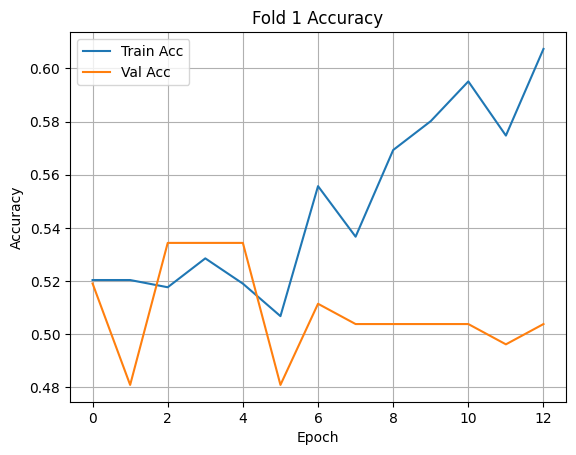

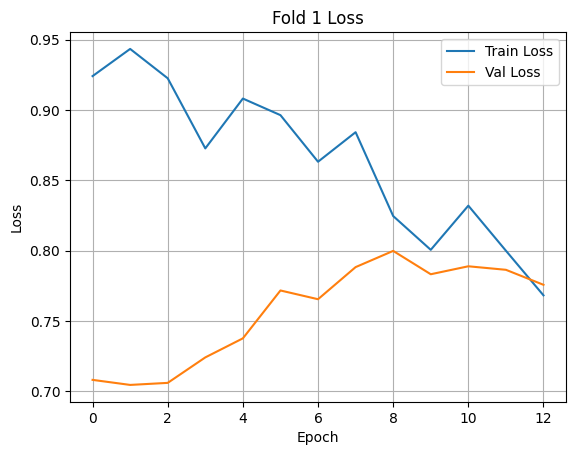

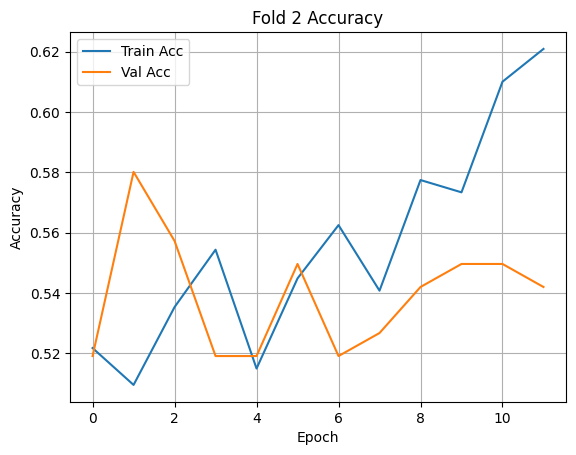

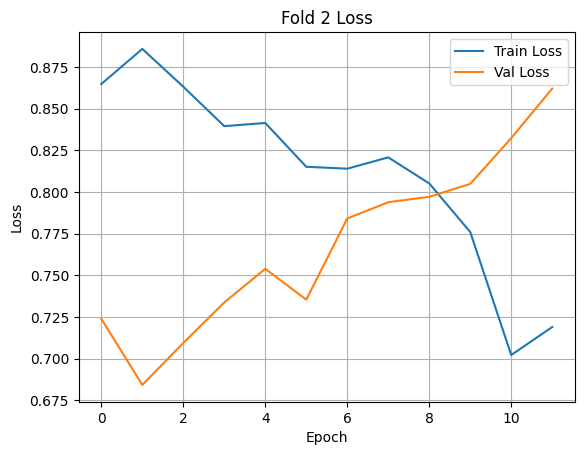

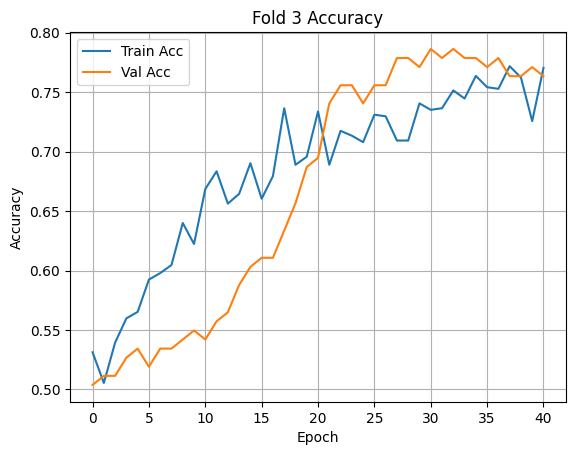

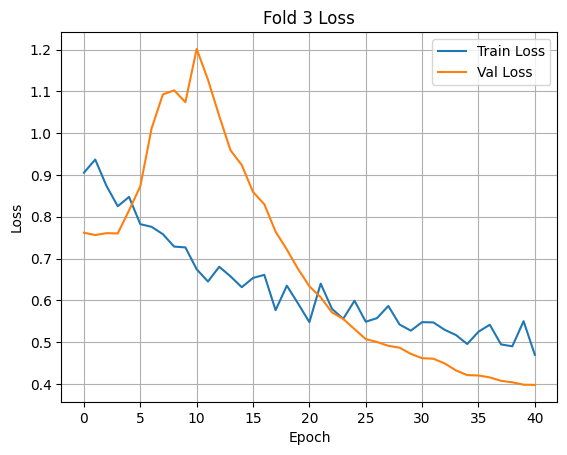

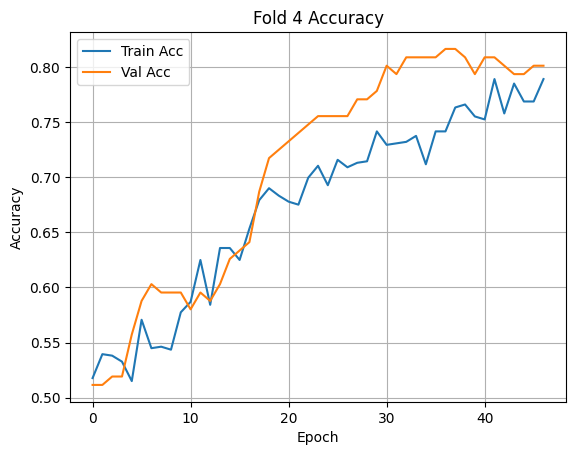

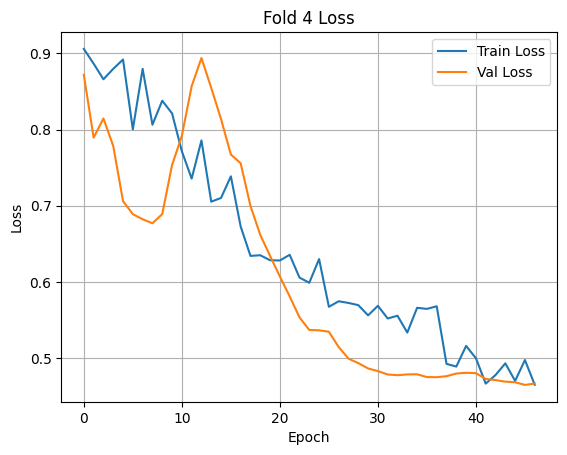

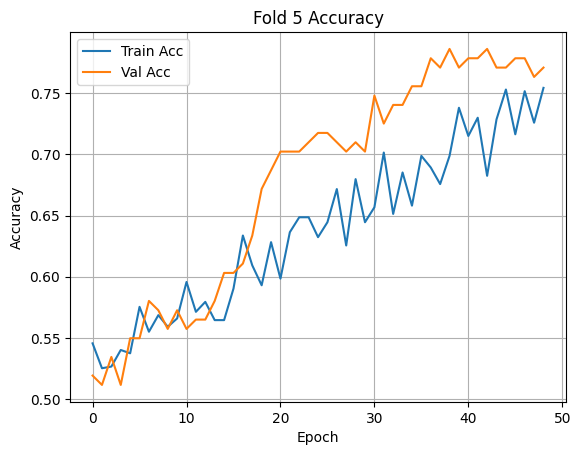

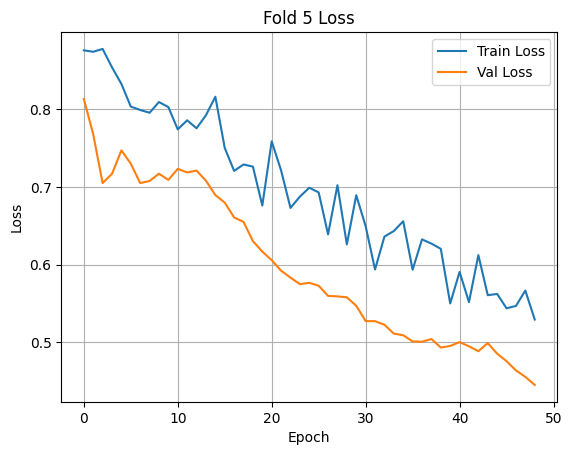

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("TCN_TemporalConvNet_Residual Blocks_final.h5")

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.611772
precision    0.508659
recall       0.530632
f1           0.514263
auc          0.745893
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,0.509259,0.509259,0.509259,0.553942
1,2,0.502304,0.000000,0.000000,0.000000,0.576453
2,3,0.769585,0.697987,0.954128,0.806202,0.877251
3,4,0.502304,0.504587,0.504587,0.504587,0.895090
4,5,0.773148,0.831461,0.685185,0.751269,0.826732


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.611772
precision    0.508659
recall       0.530632
f1           0.514263
auc          0.745893
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6118
📈 Range Accuracy: 0.2708
📉 Accuracy CV% (std/mean): 23.82%


,fold,accuracy,precision,recall,f1,auc
0,1,0.511521,0.509259,0.509259,0.509259,0.553942
1,2,0.502304,0.000000,0.000000,0.000000,0.576453
2,3,0.769585,0.697987,0.954128,0.806202,0.877251
3,4,0.502304,0.504587,0.504587,0.504587,0.895090
4,5,0.773148,0.831461,0.685185,0.751269,0.826732
